# Traitement des données

Dans cette partie, l'objectif est d'importer nos données, les convertir à un format convenable pour la production de statistiques descriptives, et exporter le résultat pour que ces bases puissent être utilisées par les autres programmes

Les bases en question sont :
- la base listant tous les incidents de violence par armes à feu aux USA entre 2013 et 2018
- la base listant les caractéristiques générales des comtés et de ses habitants.

In [1]:
#Pour le traitement classique
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon
from tqdm import tqdm

#Pour l'interaction avec l'API 
import requests
from statistics import mean
import time

## Traitement de la base d'incidents armes à feu

In [2]:
#Base incidents armes à feu
url="https://drive.google.com/file/d/1GGOLMc_Ow9yZC9sICegPegDggQuHOD3t/view?usp=drive_link"
url="https://drive.google.com/uc?export=download&confirm=1&id=" + url.split("/")[-2]
gun_violence_db = pd.read_csv(url)
gun_violence_db.sample(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
105952,477684,2016-01-02,California,Richmond,2200 block of Cutting Boulevard,0,1,http://www.gunviolencearchive.org/incident/477684,http://www.insidebayarea.com/crime-courts/ci_2...,False,...,0::52,0::Adult 18+||1::Adult 18+,0::Female||1::Male,0::Claire Dugan,NaN,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,http://www.insidebayarea.com/breaking-news/ci_...,15.0,9.0
127111,563704,2016-05-21,Michigan,Detroit,13900 block of Wyoming,0,3,http://www.gunviolencearchive.org/incident/563704,http://www.detroitnews.com/story/news/local/de...,False,...,0::20||1::21||2::21,0::Adult 18+||1::Adult 18+||2::Adult 18+,0::Male||1::Male||2::Male,NaN,NaN,0::Injured||1::Injured||2::Injured,0::Victim||1::Victim||2::Victim,http://www.detroitnews.com/story/news/local/de...,7.0,3.0
40017,216857,2014-10-03,California,Oakland,1100 10th Avenue,0,0,http://www.gunviolencearchive.org/incident/216857,https://data.oaklandnet.com/Public-Safety/Crim...,False,...,NaN,NaN,0::Male||1::Male,NaN,NaN,NaN,0::Victim||1::Subject-Suspect,https://data.oaklandnet.com/Public-Safety/Crim...,18.0,9.0
157829,737796,2016-11-22,Alaska,Soldotna,NaN,0,0,http://www.gunviolencearchive.org/incident/737796,http://www.ktuu.com/content/news/Soldotna-conv...,False,...,0::32,0::Adult 18+,0::Male,0::Scott Hashemian,NaN,"0::Unharmed, Arrested||1::Unharmed",0::Subject-Suspect||1::Subject-Suspect,http://www.ktuu.com/content/news/Soldotna-conv...,29.0,NaN
171978,774387,2017-02-14,Arkansas,Jonesboro,109 Harvester Dr,0,0,http://www.gunviolencearchive.org/incident/774387,http://www.kait8.com/story/34500618/deputys-ca...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.kait8.com/story/34500618/deputys-ca...,58.0,21.0


Conformément à la documentation de la base, certaines colonnes sont codées de façon à pouvoir les reconvertir en dictionnaire :

In [3]:
def convert_to_dict(value):
    if pd.isna(value):
        return value

    pairs = value.split('||')
    result_dict = {}
    for pair in pairs:
        #Some are corrupted : 1: instead of ::
        if '::' in pair:
            key, val = pair.split('::', 1)
            result_dict[int(key)] = val
        else:
            key, val = pair.split(':', 1)
            result_dict[int(key)] = val
    return result_dict

list_of_dict_columns = ['gun_stolen', 'gun_type', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_name', 'participant_relationship', 'participant_status', 'participant_type']
gun_violence_db[list_of_dict_columns] = gun_violence_db[list_of_dict_columns].applymap(convert_to_dict)
gun_violence_db.head()



/tmp/ipykernel_124791/4075116675.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gun_violence_db[list_of_dict_columns] = gun_violence_db[list_of_dict_columns].applymap(convert_to_dict)


,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,{0: '20'},"{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...","{0: 'Male', 1: 'Male', 3: 'Male', 4: 'Female'}",{0: 'Julian Sims'},NaN,"{0: 'Arrested', 1: 'Injured', 2: 'Injured', 3:...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Vi...",http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,{0: '20'},"{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...",{0: 'Male'},{0: 'Bernard Gillis'},NaN,"{0: 'Killed', 1: 'Injured', 2: 'Injured', 3: '...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Vi...",http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,"{0: '25', 1: '31', 2: '33', 3: '34', 4: '33'}","{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...","{0: 'Male', 1: 'Male', 2: 'Male', 3: 'Male', 4...","{0: 'Damien Bell', 1: 'Desmen Noble', 2: 'Herm...",NaN,"{0: 'Injured, Unharmed, Arrested', 1: 'Unharme...","{0: 'Subject-Suspect', 1: 'Subject-Suspect', 2...",http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,"{0: '29', 1: '33', 2: '56', 3: '33'}","{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...","{0: 'Female', 1: 'Male', 2: 'Male', 3: 'Male'}","{0: 'Stacie Philbrook', 1: 'Christopher Ratlif...",NaN,"{0: 'Killed', 1: 'Killed', 2: 'Killed', 3: 'Ki...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Su...",http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,"{0: '18', 1: '46', 2: '14', 3: '47'}","{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Teen 12-1...","{0: 'Female', 1: 'Male', 2: 'Male', 3: 'Female'}","{0: 'Danielle Imani Jameison', 1: 'Maurice Eug...",{3: 'Family'},"{0: 'Injured', 1: 'Injured', 2: 'Killed', 3: '...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Su...",http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [4]:
gun_violence_db.to_csv("data/gun_violence_db.csv", index=False)

## Traitements des bases comtés de l'API


La documentation précisant le mode d'interaction avec l'API de StLouisFed se trouve à la page https://fred.stlouisfed.org/docs/api/fred/#API.

In [112]:
#Each request is categorized with an url and an id
#The gist here is to recover the proper id to retrieve data
api_key = "180de2e6a1d1e953d270ebf38341cd44"
param = {"api_key" : api_key, "file_type" : "json", "category_id" : "27281"}
url = "https://api.stlouisfed.org/fred/category/children?"

In [109]:
def request_db(index):
    #this function requests to the API the database associated with the category id index
    param["category_id"] = index #on ajuste les paramètres de la request pour demander la bonne catégorie
    response = requests.get(url, params = param)
    data = response.json()
    return data

In [132]:
def check_response(url, param):
    while True:
        response = requests.get(url, params=param).json()

        if not response.get('error_message') or response['error_message'] != 'Too Many Requests.  Exceeded Rate Limit':
            return response
        time.sleep(5)

In [110]:
#Some names are ambiguous between dframes
def simplify_name(name):
    if name.endswith("County"):
        return name.rsplit("County", 1)[0].strip()
    if name.endswith("Parish"):
        return name.rsplit("Parish", 1)[0].strip()
    if name.endswith("Census Area"):
        return name.replace("Census Area", "CA")
    if name.endswith("Borough/city"):
        return name.replace("Borough/city", "Cty&Bor")      
    if name.endswith("Municipality"):
        return name.replace("Municipality", "Muny")
    if name.endswith("Borough/municipality"):
        return name.replace("Borough/municipality", "Muny")    
    if name.endswith("County/city"):
        return name.rsplit("County/city", 1)[0].strip() 

        
    return name

In [124]:
us_data = request_db(27281)['categories']
#We create our dframe by creating a list of dicts, each element is a new row
database = list()
for state in tqdm(us_data):
    id_state = state['id']
    state_name = state['name']
    
    #Request to recover id in order to extract counties
    state_info = request_db(id_state)["categories"]
    if state_info != []: #One exception : which one ?
        id_list_of_state_counties = state_info[0]['id']
        list_of_state_counties = request_db(id_list_of_state_counties)["categories"]
        for county in list_of_state_counties:
            dict_county = dict()
            id_county = county['id']
            
            parts = county['name'].split(', ')
            county_name, state_code = parts[0], parts[-1]
            
            dict_county = {
                'Nom': simplify_name(county_name),
                'Etat': state_name,
                'Code_Etat': state_code,
                'id_Etat': id_state,
                'id_county': id_county
            }
            
            if '+' in county_name:
                county_name, county_bis = county_name.split(' + ')
                dict_county['Nom'] = simplify_name(county_bis)
                database.append(dict_county.copy())  # Append a copy to avoid modifying the original
                dict_county['Nom'] = simplify_name(county_name)
            database.append(dict_county)

counties_db = pd.DataFrame(database)

100%|██████████| 53/53 [00:22<00:00,  2.41it/s]


In [126]:
#Gestion des exceptions pour le merging(obligé de faire du cas par cas car merging sur le code_Etat + nom)

counties_db.loc[(counties_db['Code_Etat'] == 'Aleutian Islands Census Area'), 'Code_Etat'] = 'AK'
counties_db.loc[(counties_db['Code_Etat'] == 'District of Columbia'), 'Code_Etat'] = 'DC'
counties_db.loc[(counties_db['Nom'] == 'De Soto'), 'Nom'] = 'DeSoto'
counties_db.loc[(counties_db['Nom'] == 'DeSoto') & (counties_db['Code_Etat'] == 'LA'), 'Nom'] = 'De Soto'
counties_db.loc[(counties_db['Nom'] == 'De Kalb'), 'Nom'] = 'DeKalb'
counties_db.loc[(counties_db['Nom'] == 'Du Page'), 'Nom'] = 'DuPage'
counties_db.loc[(counties_db['Nom'] == 'La Salle'), 'Nom'] = 'LaSalle'
counties_db.loc[(counties_db['Nom'] == 'La Porte'), 'Nom'] = 'LaPorte'
counties_db.loc[(counties_db['Nom'] == 'Lagrange'), 'Nom'] = 'LaGrange'
counties_db.loc[(counties_db['Nom'] == 'LaFourche'), 'Nom'] = 'Lafourche'
counties_db.loc[(counties_db['Nom'] == 'Lac Qui Parle'), 'Nom'] = 'Lac qui Parle'
counties_db.loc[(counties_db['Nom'] == 'Dona Ana'), 'Nom'] = 'Doña Ana'
counties_db.loc[(counties_db['Nom'] == 'La Moure'), 'Nom'] = 'LaMoure'
counties_db.loc[(counties_db['Nom'] == 'De Witt'), 'Nom'] = 'DeWitt'
counties_db.loc[(counties_db['Nom'] == 'DeWitt') & (counties_db['Code_Etat'] == 'IL'), 'Nom'] = 'De Witt'
counties_db.loc[(counties_db['Nom'] == 'LaSalle') & (counties_db['Code_Etat'] == 'TX'), 'Nom'] = 'La Salle'
counties_db.loc[(counties_db['Code_Etat'] == 'WI (includes Menominee)'), 'Code_Etat'] = 'WI'
counties_db.loc[(counties_db['Nom'] == 'Fond Du Lac'), 'Nom'] = 'Fond du Lac'

On a maintenant un premier dframe recensant tous les comtés des USA ainsi que les ID permettant de les retrouver dans l'API. On peut désormais extraire pour chaque comté les informations socio-démographiques nous permettant de produire nos statistiques descriptives et notre modèle.

Note : id_county fait office de clé primaire dans cette base (au sein de l'API FRED)

In [127]:
counties_db.to_csv("data/counties_db.csv", index=False)

## Récupération des données géographiques par comté

In [128]:
#On change l'URL pour pouvoir récupérer des données géographiques sur tous les comtés (ainsi que le fips, le nom simplifié)
#L'enjeu ici est d'associer les données aux comtés correspondants : les codes id de l'API n'ont pas de correspondance avec les donneés géographiques à part le nom
url = "https://api.stlouisfed.org/geofred/shapes/file?shape=county"

In [129]:
geom_counties_db = request_db(29802)#The code is arbitrary here, each request gives the geometries of all counties
geom_counties_db = gpd.GeoDataFrame.from_features(geom_counties_db['features'])
geom_counties_db = geom_counties_db.loc[geom_counties_db['hc-group'] == 'admin2']
geom_counties_db['Code_Etat'] = geom_counties_db['hc-key'].apply(lambda x: x.split('-')[1].upper() if len(x.split('-')) > 1 else None)
geom_counties_db['name'] = geom_counties_db['name'].apply(lambda x : x.rsplit("Parish", 1)[0].strip())
geom_counties_db.sample(5)


,geometry,hc-group,hc-middle-x,hc-middle-y,hc-key,hc-a2,fips,name,Code_Etat
326,"POLYGON ((7983.000 7801.000, 7945.000 7794.000...",admin2,0.53,0.49,us-ny-121,WY,36121,Wyoming,NY
2925,"POLYGON ((4463.000 8192.000, 4424.000 8214.000...",admin2,0.50,0.50,us-mn-011,BS,27011,Big Stone,MN
855,"POLYGON ((4832.000 6626.000, 4831.000 6667.000...",admin2,0.49,0.50,us-mo-047,CL,29047,Clay,MO
1976,"POLYGON ((7115.000 5323.000, 7131.000 5317.000...",admin2,0.55,0.47,us-ga-247,RO,13247,Rockdale,GA
920,"POLYGON ((4193.000 4875.000, 4200.000 4875.000...",admin2,0.50,0.51,us-tx-251,JO,48251,Johnson,TX


In [130]:
counties_db = pd.merge(left= counties_db, right=geom_counties_db, how='left', left_on=['Nom', 'Code_Etat'], right_on=['name', 'Code_Etat'])
counties_db = counties_db.loc[:,['Nom', 'Etat', 'Code_Etat', 'id_Etat', 'id_county', 'fips', 'geometry']]
counties_db.sample(10)

,Nom,Etat,Code_Etat,id_Etat,id_county,fips,geometry
1307,Ottawa,Michigan,MI,27304,28653,26139,"POLYGON ((6421.000 7626.000, 6415.000 7677.000..."
718,Dearborn,Indiana,IN,151,28056,18029,"POLYGON ((6748.000 6759.000, 6788.000 6763.000..."
2809,Utah,Utah,UT,27328,30179,49049,"POLYGON ((1586.000 7023.000, 1593.000 7022.000..."
1700,Hall,Nebraska,NE,27309,29052,31079,"POLYGON ((4012.000 6995.000, 4013.000 7045.000..."
1186,Cumberland,Maine,ME,27301,28529,23005,"POLYGON ((9286.000 8524.000, 9310.000 8518.000..."
37,Lamar,Alabama,AL,27282,27373,01075,"POLYGON ((6235.000 5336.000, 6283.000 5338.000..."
1271,Ionia,Michigan,MI,27304,28617,26067,"POLYGON ((6673.000 7747.000, 6678.000 7700.000..."
2669,Lamar,Texas,TX,27326,30037,48277,"POLYGON ((4701.000 5088.000, 4644.000 5112.000..."
2734,San Jacinto,Texas,TX,27326,30102,48407,"POLYGON ((4695.000 4336.000, 4698.000 4368.000..."
1222,Wicomico,Maryland,MD,27302,28566,24045,"POLYGON ((8633.000 6842.000, 8631.000 6844.000..."


Les comtés où la jointure géographique n'est pas possible :

In [131]:
counties_db.loc[counties_db['geometry'] == None]

,Nom,Etat,Code_Etat,id_Etat,id_county,fips,geometry
68,Aleutian Islands CA,Alaska,AK,27283,33743,NaN,None
90,Prince of Wales-Outer Ketchikan CA,Alaska,AK,27283,27421,NaN,None
92,Skagway-Hoonah-Angoon CA,Alaska,AK,27283,27423,NaN,None
96,Wade Hampton CA,Alaska,AK,27283,27426,NaN,None
97,Wrangell Borough/City,Alaska,AK,27283,33518,NaN,None
98,Wrangell-Petersburg CA,Alaska,AK,27283,27427,NaN,None
99,Yakutat City and Borough,Alaska,Yakutat City and Borough,27283,32212,NaN,None
556,Kalawao Counties,Hawaii,HI,27293,33804,NaN,None
2425,Shannon,South Dakota,SD,27324,29791,NaN,None
2856,Clifton Forge City,Virginia,VA,27330,30228,NaN,None


## Récupération des séries FRED

Ici, le but est de récupérer des données clé pour chaque comté : population, taux de chômage, bénéficiaires d'aides sociales etc.

In [12]:
#Attempt to optimize the execution time + retrieve multiple series all at once
#Step 1 : Retrieve the ID of all series
dict_series = {}
for id_county in tqdm(counties_db['id_county']):
    url = "https://api.stlouisfed.org/fred/category/series?"
    param = {"api_key" : api_key, "file_type" : "json", "category_id" : id_county}
    response = check_response(url, param)

    dict_series[id_county] = response['seriess']

100%|██████████| 3195/3195 [26:25<00:00,  2.02it/s]  


In [95]:
#Step 2 : Retrieve the ID of the specific series we want to study
series_to_retrieve = {}
for id_county in tqdm(counties_db['id_county']):
    unemp_rate_id = med_h_income_id = 'not found'
    for serie in dict_series[id_county]:
        if ("Unemployment Rate" in serie["title"]) and ("Monthly" in serie["frequency"]):
            unemp_rate_id = serie['id']
        if ("Estimate of Median Household Income" in serie["title"]) and ("Interval" not in serie["title"]):
            med_h_income_id = serie['id']
    series_to_retrieve[id_county] = (unemp_rate_id, med_h_income_id)
#eg : series_to_retrieve = {id_county_1 : (series_1_id, series_2_id, ...)}

100%|██████████| 3195/3195 [00:00<00:00, 4069.60it/s]


In [99]:
#Step 3 : Determine the value associated with the series
list_of_values = {}
for id_county in tqdm(counties_db['id_county']):
    list_of_values[id_county] = [np.nan]*2 #Here 2=nb of variables
    for index, id_series in enumerate(series_to_retrieve[id_county]):
        #Here, list_of_series = (series_1_id, series_2_id, ...)
        #For now, suppose that all data are means

        if id_series == 'not found':
            list_of_values[id_county][index] = None
            continue

        #Request data
        url = "https://api.stlouisfed.org/fred/series/observations?"
        param = {"api_key" : api_key, "file_type" : "json", "series_id" : id_series, "observation_start" : "2013-01-01", "observation_end" : "2018-01-01"} 
        observations = check_response(url, param)['observations']

        #Mean of all obs points
        value = np.nan
        list_points= [float(obs["value"]) for obs in observations]
        if len(list_points) > 1:
            value = mean(list_points)

        #Save the mean value
        list_of_values[id_county][index] = value

100%|██████████| 3195/3195 [52:11<00:00,  1.02it/s]  


In [136]:
#Step 4 : Convert data in a dataframe, then merge it to obtain our final db

fred_db = pd.DataFrame.from_dict(list_of_values, orient='index', columns=['unemp_rate', 'med_h_income'])
fred_db.reset_index(inplace=True)
fred_db.rename(columns={'index': 'id_county'}, inplace=True)
fred_db.head(5)

counties_db = pd.merge(left= counties_db, right=fred_db, how='left', left_on='id_county', right_on='id_county')


In [137]:
counties_db

,Nom,Etat,Code_Etat,id_Etat,id_county,fips,geometry,unemp_rate,med_h_income
0,Autauga,Alabama,AL,27282,27336,01001,"POLYGON ((6581.000 4919.000, 6555.000 4969.000...",5.263934,55830.333333
1,Baldwin,Alabama,AL,27282,27337,01003,"MULTIPOLYGON (((6355.000 4470.000, 6354.000 44...",5.568852,53367.833333
2,Barbour,Alabama,AL,27282,27338,01005,"POLYGON ((6976.000 4890.000, 6979.000 4880.000...",8.768852,32856.833333
3,Bibb,Alabama,AL,27282,27339,01007,"POLYGON ((6431.000 5078.000, 6453.000 5080.000...",6.518033,42505.333333
4,Blount,Alabama,AL,27282,27340,01009,"POLYGON ((6608.000 5424.000, 6619.000 5411.000...",5.457377,47720.666667
...,...,...,...,...,...,...,...,...,...
3190,Sweetwater,Wyoming,WY,27334,30524,56037,"POLYGON ((1838.000 7537.000, 1847.000 7605.000...",4.795082,73470.166667
3191,Teton,Wyoming,WY,27334,30525,56039,"POLYGON ((1787.000 7869.000, 1743.000 7876.000...",4.219672,83698.166667
3192,Uinta,Wyoming,WY,27334,30526,56041,"POLYGON ((1614.000 7375.000, 1619.000 7403.000...",5.168852,62706.500000
3193,Washakie,Wyoming,WY,27334,30527,56043,"POLYGON ((2369.000 7855.000, 2361.000 7856.000...",4.527869,53390.333333


<Axes: >

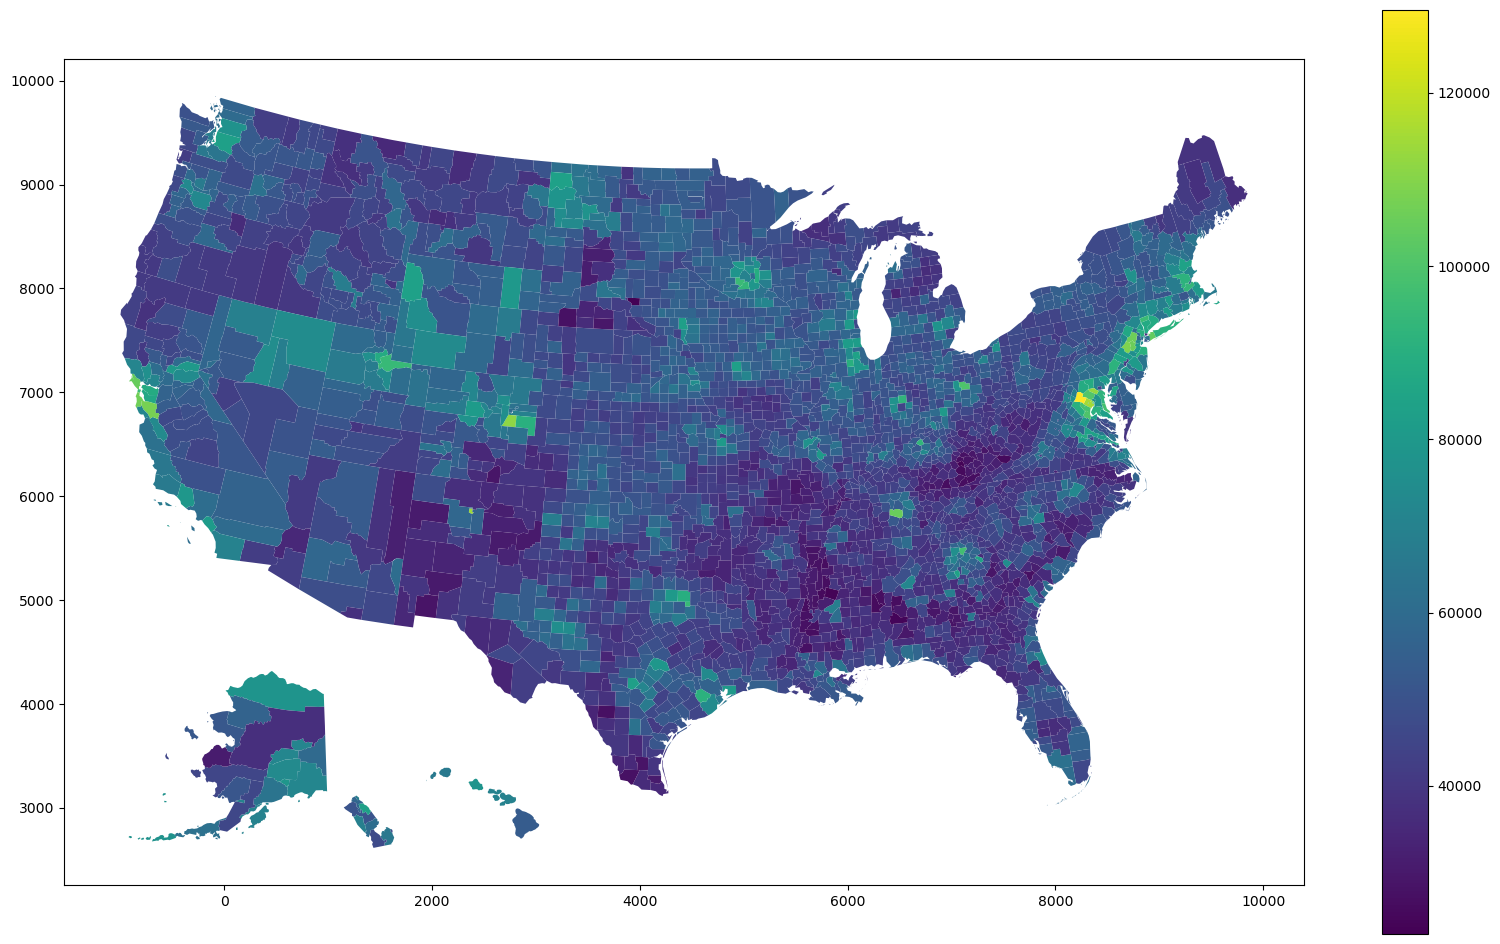

In [138]:
test_db = gpd.GeoDataFrame(counties_db)
test_db.plot('med_h_income', legend=True, figsize=(20,12))